In [1]:
# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math
import re

# Import sklearn libraries
from sklearn import svm
import sklearn.model_selection as ms
import sklearn.feature_extraction.text as text
import sklearn.naive_bayes as nb
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Data cleansing

In [24]:
# Read in the statements
statements = pd.read_csv("fomc_statement.csv",parse_dates=["Date",])
yields = pd.read_csv("DailyTreasuryYield.csv",parse_dates=["Date",])
print(statements.head())
print(yields.head())
print(len(statements))
print(len(yields))

        Date                                          Statement
0 1994-02-04  Chairman Alan Greenspan announced today that t...
1 1994-03-22  Chairman Alan Greenspan announced today that t...
2 1994-05-17  The Federal Reserve today announced two action...
3 1994-08-16  The Federal Reserve announced today the follow...
4 1994-11-15  The Federal Reserve Board today approved an in...
        Date  1 MO  3 MO  6 MO  1 YR  2 YR  3 YR  5 YR  7 YR  10 YR  20 YR  \
0 1990-01-02   NaN  7.83  7.89  7.81  7.87  7.90  7.87  7.98   7.94    NaN   
1 1990-01-03   NaN  7.89  7.94  7.85  7.94  7.96  7.92  8.04   7.99    NaN   
2 1990-01-04   NaN  7.84  7.90  7.82  7.92  7.93  7.91  8.02   7.98    NaN   
3 1990-01-05   NaN  7.79  7.85  7.79  7.90  7.94  7.92  8.03   7.99    NaN   
4 1990-01-08   NaN  7.79  7.88  7.81  7.90  7.95  7.92  8.05   8.02    NaN   

   30 YR  
0   8.00  
1   8.04  
2   8.04  
3   8.06  
4   8.09  
184
7443


In [25]:
# Correct one FOMC website mistake
statements.loc[statements["Date"] == datetime.date(2007, 6, 18), "Date"] = datetime.date(2007, 6, 28)
statements.sort_values(by='Date', inplace=True)
# Change a weekend to the latest business date
statements.loc[statements["Date"] == datetime.date(2010, 5, 9), "Date"] = datetime.date(2010, 5, 7)

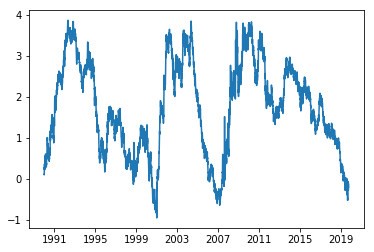

In [26]:
plt.plot(yields["Date"],yields["10 YR"] - yields["3 MO"])

In [27]:
result = pd.merge(yields, statements, on='Date', how='left')
result['10YR_3MO'] = result['10 YR']-result['3 MO']
result['d3MO'] = result['3 MO'].diff()
result['d_structure'] = result['10YR_3MO'].diff()

In [28]:
result.head(10)

,Date,1 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR,Statement,10YR_3MO,d3MO,d_structure
0,1990-01-02,NaN,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,NaN,8.00,NaN,0.11,NaN,NaN
1,1990-01-03,NaN,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,NaN,8.04,NaN,0.10,0.06,-0.01
2,1990-01-04,NaN,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,NaN,8.04,NaN,0.14,-0.05,0.04
3,1990-01-05,NaN,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,NaN,8.06,NaN,0.20,-0.05,0.06
4,1990-01-08,NaN,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,NaN,8.09,NaN,0.23,0.00,0.03
5,1990-01-09,NaN,7.80,7.82,7.78,7.91,7.94,7.92,8.05,8.02,NaN,8.10,NaN,0.22,0.01,-0.01
6,1990-01-10,NaN,7.75,7.78,7.77,7.91,7.95,7.92,8.00,8.03,NaN,8.11,NaN,0.28,-0.05,0.06
7,1990-01-11,NaN,7.80,7.80,7.77,7.91,7.95,7.94,8.01,8.04,NaN,8.11,NaN,0.24,0.05,-0.04
8,1990-01-12,NaN,7.74,7.81,7.76,7.93,7.98,7.99,8.07,8.10,NaN,8.17,NaN,0.36,-0.06,0.12
9,1990-01-16,NaN,7.89,7.99,7.92,8.10,8.13,8.11,8.18,8.20,NaN,8.25,NaN,0.31,0.15,-0.05


In [29]:
result[result['Statement'].notnull()].head(10)

,Date,1 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR,Statement,10YR_3MO,d3MO,d_structure
1024,1994-02-04,NaN,3.30,3.49,3.84,4.42,4.75,5.32,5.62,5.94,6.49,6.37,Chairman Alan Greenspan announced today that t...,2.64,0.10,0.03
1055,1994-03-22,NaN,3.60,3.94,4.33,5.03,5.38,5.92,6.24,6.44,6.94,6.85,Chairman Alan Greenspan announced today that t...,2.84,-0.10,-0.01
1093,1994-05-17,NaN,4.30,4.77,5.29,5.88,6.23,6.66,6.85,7.03,7.39,7.27,The Federal Reserve today announced two action...,2.73,-0.01,-0.20
1156,1994-08-16,NaN,4.74,5.17,5.62,6.21,6.52,6.86,7.02,7.19,7.56,7.39,The Federal Reserve announced today the follow...,2.45,0.02,-0.13
1218,1994-11-15,NaN,5.53,6.03,6.55,7.10,7.41,7.69,7.78,7.92,8.15,8.05,The Federal Reserve Board today approved an in...,2.39,0.07,-0.09
1270,1995-02-01,NaN,6.07,6.49,6.97,7.33,7.44,7.56,7.65,7.66,7.85,7.75,The Federal Reserve Board today approved an in...,1.59,0.07,-0.01
1377,1995-07-06,NaN,5.53,5.50,5.43,5.56,5.64,5.75,5.97,6.05,6.53,6.51,Chairman Alan Greenspan announced today that t...,0.52,-0.15,0.01
1492,1995-12-19,NaN,5.24,5.31,5.28,5.36,5.45,5.58,5.71,5.81,6.21,6.14,Chairman Alan Greenspan announced today that t...,0.57,-0.08,0.04
1520,1996-01-31,NaN,5.05,4.97,4.90,4.93,5.06,5.25,5.46,5.60,6.07,6.03,The Federal Reserve today announced the follow...,0.55,-0.09,0.06
1808,1997-03-25,NaN,5.44,5.60,5.91,6.33,6.48,6.63,6.72,6.75,7.07,6.95,The Federal Open Market Committee decided toda...,1.31,0.04,-0.01


In [30]:
# generate rates movement for each release date
myDates = result[result['Statement'].notnull()]['Date']
window = 3 # business days
for i in range(len(myDates)):
    start_index = myDates.index[i]
    if i == len(myDates) - 1:
        policy_interim = np.inf
    else: 
        policy_interim = myDates.index[i+1] - myDates.index[i]
    sub_result = result.iloc[start_index:min(start_index+window,start_index+policy_interim)]
    result.loc[result["Date"] == myDates.iloc[i], "3MO_move"] = sub_result['d3MO'].sum()
    result.loc[result["Date"] == myDates.iloc[i], "3MO_std"] = sub_result['d3MO'].std()
    result.loc[result["Date"] == myDates.iloc[i], "structure_move"] = sub_result['d_structure'].sum()
    result.loc[result["Date"] == myDates.iloc[i], "structure_std"] = sub_result['d_structure'].std()

In [31]:
out = result[result['Statement'].notnull()]
out.head(5)

,Date,1 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR,Statement,10YR_3MO,d3MO,d_structure,3MO_move,3MO_std,structure_move,structure_std
1024,1994-02-04,NaN,3.30,3.49,3.84,4.42,4.75,5.32,5.62,5.94,6.49,6.37,Chairman Alan Greenspan announced today that t...,2.64,0.10,0.03,0.12,0.051962,0.08,0.015275
1055,1994-03-22,NaN,3.60,3.94,4.33,5.03,5.38,5.92,6.24,6.44,6.94,6.85,Chairman Alan Greenspan announced today that t...,2.84,-0.10,-0.01,-0.17,0.045092,0.20,0.080208
1093,1994-05-17,NaN,4.30,4.77,5.29,5.88,6.23,6.66,6.85,7.03,7.39,7.27,The Federal Reserve today announced two action...,2.73,-0.01,-0.20,-0.07,0.023094,-0.21,0.113578
1156,1994-08-16,NaN,4.74,5.17,5.62,6.21,6.52,6.86,7.02,7.19,7.56,7.39,The Federal Reserve announced today the follow...,2.45,0.02,-0.13,-0.01,0.040415,-0.01,0.120554
1218,1994-11-15,NaN,5.53,6.03,6.55,7.10,7.41,7.69,7.78,7.92,8.15,8.05,The Federal Reserve Board today approved an in...,2.39,0.07,-0.09,0.05,0.046188,0.04,0.089629


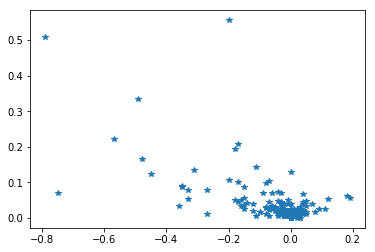

In [32]:
plt.plot(out['3MO_move'], out['3MO_std'],'*')

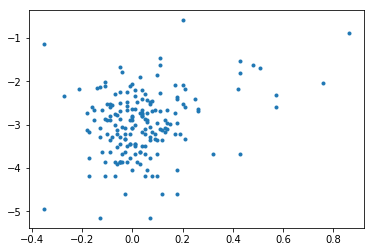

In [33]:
plt.plot(out['structure_move'], np.log(out['structure_std']),'.')

In [34]:
out['3MO_label'] = out['3MO_move'] > 0
out['structure_label'] = out['structure_move'] > 0

/Users/fohanlin/PycharmProjects/w266NLP/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/fohanlin/PycharmProjects/w266NLP/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [35]:
out.head()

,Date,1 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,...,Statement,10YR_3MO,d3MO,d_structure,3MO_move,3MO_std,structure_move,structure_std,3MO_label,structure_label
1024,1994-02-04,NaN,3.30,3.49,3.84,4.42,4.75,5.32,5.62,5.94,...,Chairman Alan Greenspan announced today that t...,2.64,0.10,0.03,0.12,0.051962,0.08,0.015275,True,True
1055,1994-03-22,NaN,3.60,3.94,4.33,5.03,5.38,5.92,6.24,6.44,...,Chairman Alan Greenspan announced today that t...,2.84,-0.10,-0.01,-0.17,0.045092,0.20,0.080208,False,True
1093,1994-05-17,NaN,4.30,4.77,5.29,5.88,6.23,6.66,6.85,7.03,...,The Federal Reserve today announced two action...,2.73,-0.01,-0.20,-0.07,0.023094,-0.21,0.113578,False,False
1156,1994-08-16,NaN,4.74,5.17,5.62,6.21,6.52,6.86,7.02,7.19,...,The Federal Reserve announced today the follow...,2.45,0.02,-0.13,-0.01,0.040415,-0.01,0.120554,False,False
1218,1994-11-15,NaN,5.53,6.03,6.55,7.10,7.41,7.69,7.78,7.92,...,The Federal Reserve Board today approved an in...,2.39,0.07,-0.09,0.05,0.046188,0.04,0.089629,True,True


# Model

In [36]:
# Identify labels
y = out['structure_label'] #out['3MO_label']

# Implement Tfid vectorizer
vectorizer = text.TfidfVectorizer(stop_words=['about','the','committee', "ben", "geithner", "bernanke", "timothy", "hoenig", "thomas", "donald", "kevin", "mishkin", "kroszner", "kohn", "charles", "frederic"])

def textfilter(x):
    out = re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', '',x)
    out = re.sub(r'\d+','',x)
    return out

X = vectorizer.fit_transform(map(textfilter,out['Statement'].values))
print(X.shape)

(184, 1682)


In [37]:
print(vectorizer.get_feature_names())

['aaa', 'abate', 'abating', 'ability', 'above', 'abroad', 'absence', 'absent', 'accelerated', 'accelerates', 'accelerating', 'accommodate', 'accommodation', 'accommodative', 'accompanying', 'accordingly', 'account', 'accumulated', 'achieved', 'achieving', 'act', 'action', 'actions', 'activity', 'actual', 'add', 'addendum', 'addition', 'additional', 'address', 'addressed', 'adhoc', 'adjust', 'adjusting', 'adjustment', 'adjustments', 'adopt', 'adopted', 'advance', 'advanced', 'advances', 'advancing', 'adverse', 'affect', 'affected', 'affords', 'after', 'aftermath', 'again', 'against', 'agency', 'aggregate', 'aggressive', 'ago', 'agreed', 'ahead', 'alan', 'albeit', 'alert', 'alfred', 'alignment', 'all', 'allotment', 'allowed', 'almost', 'along', 'already', 'also', 'alter', 'altered', 'alternate', 'although', 'always', 'among', 'amount', 'amounts', 'an', 'analysts', 'anchored', 'and', 'announce', 'announced', 'announcement', 'announcements', 'announcing', 'anthony', 'anticipate', 'anticipa

In [38]:
print(vectorizer.get_stop_words())

frozenset({'kevin', 'frederic', 'hoenig', 'the', 'bernanke', 'geithner', 'mishkin', 'charles', 'kroszner', 'donald', 'about', 'ben', 'kohn', 'committee', 'timothy', 'thomas'})


In [39]:
seed = 10
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.1,random_state=seed)

In [40]:
y.describe()

count      184
unique       2
top       True
freq        99
Name: structure_label, dtype: object

## Prediction

### Naive Bayes

In [41]:
# Use GridSearchCV to find optimal alpha
nb_model = ms.GridSearchCV(nb.BernoulliNB(), param_grid={'alpha': np.logspace(-2., 2., 50)})
nb_model.fit(X_train, y_train)

/Users/fohanlin/PycharmProjects/w266NLP/venv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/fohanlin/PycharmProjects/w266NLP/venv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None,
                                   fit_prior=True),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([1.00000000e-02, 1.20679264e-02, 1.45634848e-02, 1.75751062e-02,
       2.12095089e-02, 2.55954792e-02, 3.08884360e-02, 3.72759372e-02,
       4.49843267e-02, 5.42867544e-02, 6.55128557e-02, 7....
       4.09491506e+00, 4.94171336e+00, 5.96362332e+00, 7.19685673e+00,
       8.68511374e+00, 1.04811313e+01, 1.26485522e+01, 1.52641797e+01,
       1.84206997e+01, 2.22299648e+01, 2.68269580e+01, 3.23745754e+01,
       3.90693994e+01, 4.71486636e+01, 5.68986603e+01, 6.86648845e+01,
       8.28642773e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [42]:
nb_model.score(X_test, y_test)

0.6842105263157895

### SVM

In [43]:
svm_model = ms.GridSearchCV(svm.SVC(kernel='rbf'), 
                            {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma' : [0.001, 0.01, 0.1, 1]}, 
                            cv=5)
svm_model.fit(X_train, y_train)

/Users/fohanlin/PycharmProjects/w266NLP/venv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'gamma': [0.001, 0.01, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [44]:
svm_model.score(X_test, y_test)

0.6842105263157895

In [45]:
y_test.describe()

count       19
unique       2
top       True
freq        10
Name: structure_label, dtype: object

## Sentiment Analysis

In [50]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [54]:
stop_words = list(set(stopwords.words('english')))
type(stop_words)

list

In [55]:
import pysentiment as ps

In [67]:
def assignSentmentScore(x):
    lm = ps.LM()
    tokens = lm.tokenize(x)
    score = lm.get_score(tokens)
    return score['Polarity']

In [71]:
sentimentScore = list(map(assignSentmentScore,out['Statement'].values))

In [73]:
len(sentimentScore)

184

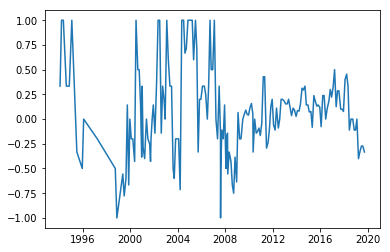

In [76]:
plt.plot(out['Date'],sentimentScore)